# TiVo - Segmentation Analysis using _k_-means Clustering

**NOTE**: All cells that have Excercises in them are marked with `#EXERCISE-TODO-[NO OF EXERCISE]`

## Import General Packages

In [ ]:
##NOTE: ONLY RUN THIS AGAIN BY UNCOMMENTING IF YOU HAVEN'T RUN THIS IN ETL FILE ALREADY
#%pip install -r requirements.txt

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in ETL pipeline data

Read in two files:
1. the standardized data from which we will find clusters
1. the original data of our selected descriptors, to use in post-clustering analysis

In [38]:
dtivo_std = pd.read_csv("data/dtivo_standardized.csv",
                        index_col="ID")
dtivo_std.head()

,Income,Age,ElecSpend_Annual,Ed_Coded,Male
ID,,,,,
3,2.156536,1.046405,1.999336,0.353368,0.904305
6,-0.387246,1.376349,-0.798654,0.353368,-1.105822
7,-0.198818,0.826443,-0.574815,-0.727044,0.904305
8,-0.575674,-0.933254,-0.295016,-0.727044,0.904305
9,2.062321,0.716462,2.558934,-0.727044,0.904305


In [39]:
dtivo_desc = pd.read_csv("data/dtivo_descriptors.csv",
                         index_col="ID")
dtivo_desc.head()

,Income,Age,ElecSpend_Annual,Ed_Coded,Male
ID,,,,,
3,58,66,768,2,1
6,31,72,168,2,0
7,33,62,216,1,1
8,29,30,276,1,1
9,57,60,888,1,1


## K-means Clustering

### Basic approach - assuming we want K=4

In [40]:
#Import Required Packages
from sklearn.cluster import KMeans

#### Fitting the k-means model for k=4

In [41]:
#Fit 4 clusters using KMeans to standardized data
k4_model = KMeans(n_clusters=4, 
                  random_state=111).fit(dtivo_std)

#### Tagging the segmentation bases dataset with cluster numbers

In [42]:
# Tag original data with the clusters for analysis reporting
dtivo_k4 = dtivo_desc.copy()
dtivo_k4['k4'] = k4_model.labels_
dtivo_k4.head()

,Income,Age,ElecSpend_Annual,Ed_Coded,Male,k4
ID,,,,,,
3,58,66,768,2,1,3
6,31,72,168,2,0,2
7,33,62,216,1,1,1
8,29,30,276,1,1,1
9,57,60,888,1,1,3


In [43]:
dtivo_k4.to_csv("outputs/dtivo_k4.csv")

#### Basic summary table

In [44]:
#TODO-18: Select appropriate metrics to summarize the cluster features.
pivot_k4 = dtivo_k4.groupby('k4').agg(['mean', 'std']).round(1)
pivot_k4.insert(0, 'Size', dtivo_k4.groupby('k4').size())
pivot_k4

Size Income        Age       ElecSpend_Annual        Ed_Coded      Male  \
          mean  std  mean   std             mean    std     mean  std mean   
k4                                                                           
0   123   30.4  4.3  27.3  10.8            372.1   78.6      3.1  0.8  0.5   
1   267   30.0  3.6  52.6  16.8            214.5   56.5      1.2  0.4  1.0   
2   245   29.9  3.1  48.5  17.3            213.3   61.8      1.2  0.4  0.0   
3   163   54.8  3.7  50.3  16.4            708.2  153.0      2.2  0.8  0.7   

         
    std  
k4       
0   0.5  
1   0.0  
2   0.0  
3   0.5

#### Calculating the Value of a Cluster
Both size and spending per annum of each person in that cluster matters in this scenario.  So we can value the segments by using these.

In [86]:
pivot_k4['Value ($)'] = pivot_k4['ElecSpend_Annual']['mean']*pivot_k4['Size']
pivot_k4

Size Income        Age       ElecSpend_Annual        Ed_Coded      Male  \
          mean  std  mean   std             mean    std     mean  std mean   
k4                                                                           
0   123   30.4  4.3  27.3  10.8            372.1   78.6      3.1  0.8  0.5   
1   267   30.0  3.6  52.6  16.8            214.5   56.5      1.2  0.4  1.0   
2   245   29.9  3.1  48.5  17.3            213.3   61.8      1.2  0.4  0.0   
3   163   54.8  3.7  50.3  16.4            708.2  153.0      2.2  0.8  0.7   

        Value ($)  
    std            
k4                 
0   0.5   45768.3  
1   0.0   57271.5  
2   0.0   52258.5  
3   0.5  115436.6

#### PROBLEM WITH OUR CLUSTERS?
There is one cluster which is too small to represent our future market.  It contains outliers.
 


 #### SOLUTION
 1. Identify the outliers
 1. Drop them from pipeline stage above. Use the dropping code **_there_** to drop the 2 records that are outliers (As k-means has some randomness in it, your cluster number may be different for the 2 records - please adjust code for that)


In [37]:
outlierIDs = dtivo_k4[dtivo_k4['k4']==3].index
print(outlierIDs)

Index([441, 923], dtype='int64', name='ID')


In [ ]:
#DO NOT USE THIS CODE HERE - MOVE IT BACK TO THE TOP AFTER LOADING THESE FILES
#ALSO NOTE: IT WILL ONLY WORK IF YOU HAVE ALREADY DEFINED outlierIDs before running it.
#dtivo_std.drop(index=outlierIDs, inplace=True)
#len(dtivo_std)
#dtivo_desc.drop(index=outlierIDs, inplace=True)
#len(dtivo_desc)

#### Using a Heatmap on the Summary Table to understand the Clusters (k=4)

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

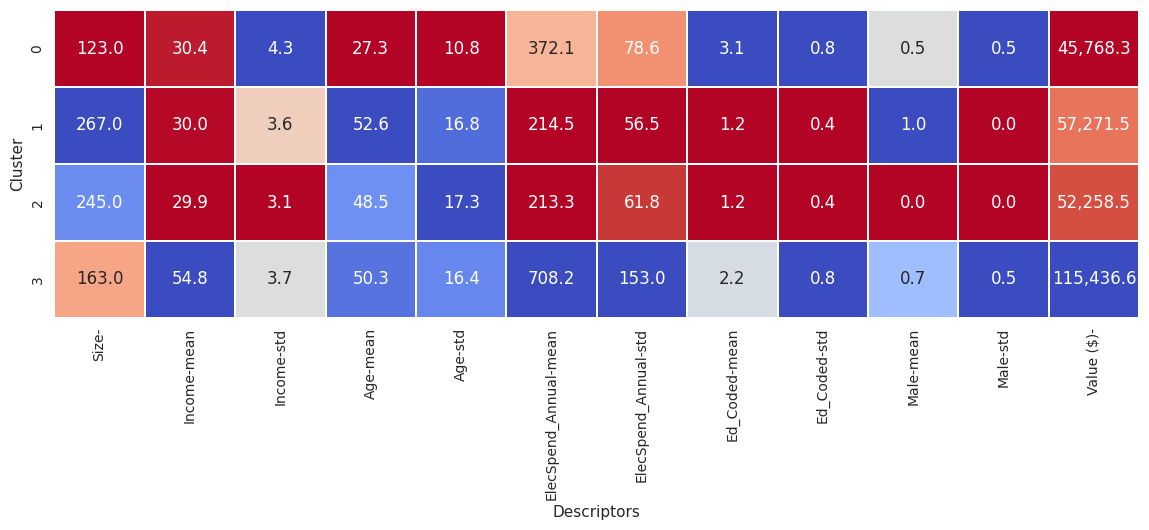

In [90]:
pk4mins = pivot_k4.min(0)
pk4maxs = pivot_k4.max(0)
mm_pivot = (pivot_k4 - pk4mins)/(pk4maxs-pk4mins)
fig = plt.figure(figsize=(14, 4))
pk4_map = sns.heatmap(
    mm_pivot,
    annot=pivot_k4,  #actual pivot becomes annotation
    cmap='coolwarm_r',
    cbar=False,
    fmt=',.1f',
    lw=0.01)

pk4_map.set(xlabel='Descriptors',
           ylabel = 'Cluster')
plt.show()

In [91]:
fig.savefig('figs/heatmap_k4_tivo.png', dpi=300, bbox_inches='tight')

#### Defining clusters with 'persona' descriptions
Edit the descriptors according to what you think is a defining feature.  It should inform your marketing team

In [50]:
pivot_k4_annot = pivot_k4.copy()
pivot_k4_annot['Persona'] = ['Young Moderate Spenders',
                             'Educated High-Spending Men',
                             '????',
                             '????'
                            ]
pivot_k4_annot

Size Income        Age       ElecSpend_Annual        Ed_Coded      Male  \
          mean  std  mean   std             mean    std     mean  std mean   
k4                                                                           
0   123   30.4  4.3  27.3  10.8            372.1   78.6      3.1  0.8  0.5   
1   267   30.0  3.6  52.6  16.8            214.5   56.5      1.2  0.4  1.0   
2   245   29.9  3.1  48.5  17.3            213.3   61.8      1.2  0.4  0.0   
3   163   54.8  3.7  50.3  16.4            708.2  153.0      2.2  0.8  0.7   

                            Persona  
    std                              
k4                                   
0   0.5     Young Moderate Spenders  
1   0.0  Educated High-Spending Men  
2   0.0                        ????  
3   0.5                        ????

In [51]:
pivot_k4_annot.to_excel('outputs/pivot_k4_tivo.xlsx')

#### Box plots: visualize heterogeneity and homogeneity by feature

In [64]:
#We have to use the standardized dataframe to show all features on one scale
dtivo_stdk4 = dtivo_std.copy()
dtivo_stdk4['k4'] = k4_model.labels_
dtivo_stdk4.head()

,Income,Age,ElecSpend_Annual,Ed_Coded,Male,k4
ID,,,,,,
3,2.156536,1.046405,1.999336,0.353368,0.904305,3
6,-0.387246,1.376349,-0.798654,0.353368,-1.105822,2
7,-0.198818,0.826443,-0.574815,-0.727044,0.904305,1
8,-0.575674,-0.933254,-0.295016,-0.727044,0.904305,1
9,2.062321,0.716462,2.558934,-0.727044,0.904305,3


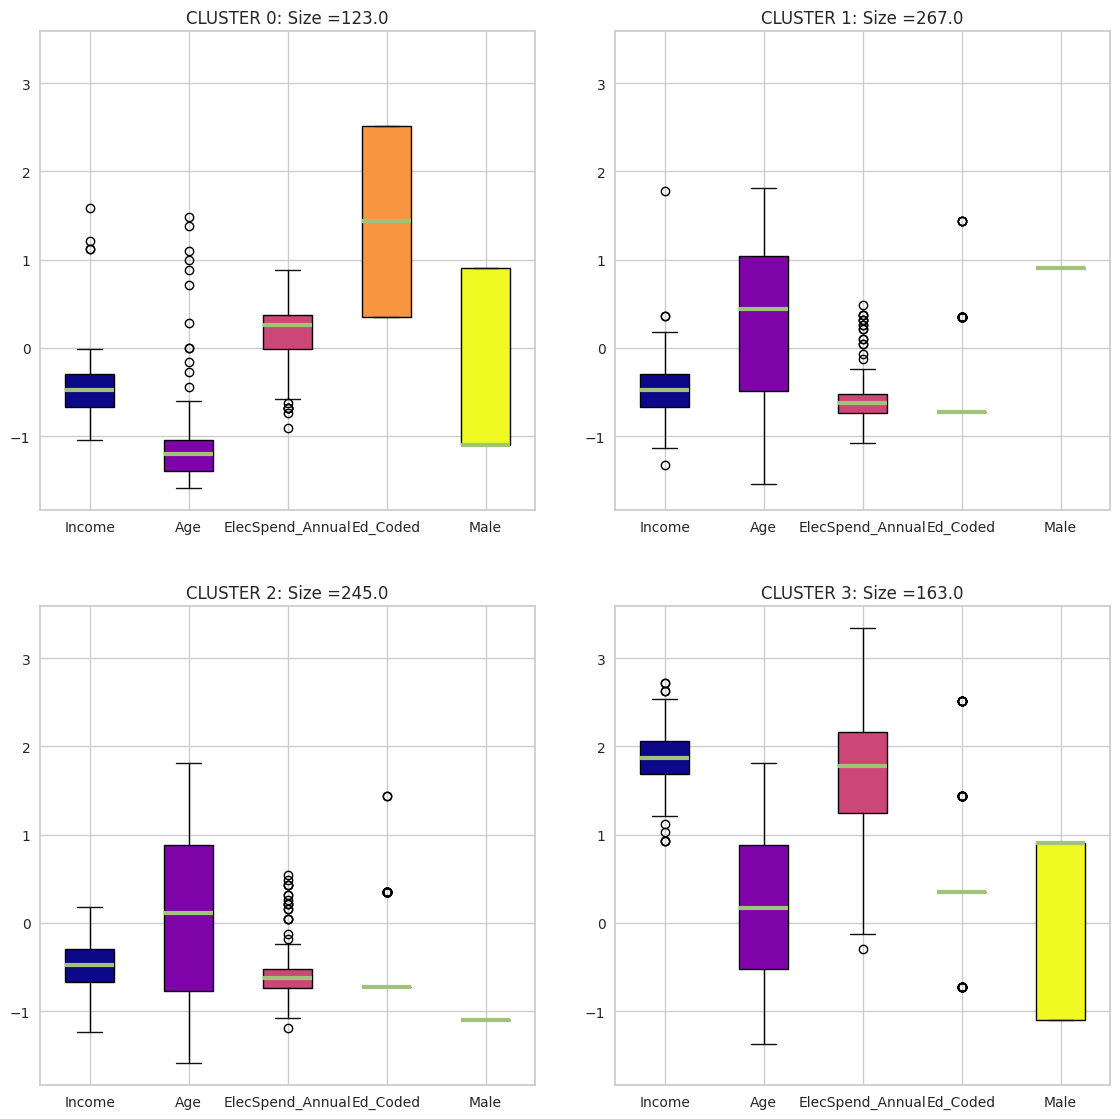

In [82]:
colsKept = list(dtivo_std.columns)
medprops = dict(linewidth=3)  #line width of median in box plot.

gpbxplot = dtivo_stdk4.groupby('k4').boxplot(column= colsKept,
                                             figsize=(12, 12),
                                             patch_artist=True,     #patches are the boxes - True allows us to change its colors
                                             medianprops=medprops)  #can change the median line properties using median props
#Amending the coloring
bxcmap = plt.get_cmap('plasma', len(colsKept))
bxcolors = [bxcmap(i) for i in range(0,len(colsKept))]
for i, ax in enumerate(gpbxplot):
    ax.set_title(f"CLUSTER {i}: Size ={pivot_k4.loc[i,'Size'].iat[0]}")
    ax.tick_params(labelleft=True)
    for j, patch in enumerate(ax.patches):
        patch.set_facecolor(bxcolors[j])
plt.tight_layout(pad=3.0)
#gpbxplot[1].get_figure()

In [ ]:
#TODO-32: How do we save the plot?
fig_k6boxplot = gpbxplot[1].get_figure()
fig_k6boxplot.savefig('boxplot_k6.png', dpi=400)

### BUT - What if we are trying to find the best 'k'?

#### Method #1: 'Elbow' method - one way to visualise distances within clusters

In scikit-learn's KMeans algorithm, the attribute `inertia_` represents the sum of squared distances of samples to their nearest cluster center. It is a measure of how well the data points are clustered. Lower inertia values indicate that the data points are closer to their respective cluster centers, which generally means better clustering¹.

We will use this to see which clustering has a reasonably acceptable inertia

(1) k_means — scikit-learn 1.5.2 documentation. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html.


In [53]:
k4_model.inertia_

1415.9484311173583

In [ ]:
##ONLY INSTALL THE FOLLOWING IF YOU DIDN'T INSTALL REQUIREMENTS
##AND ARE USING YOUR OWN PANDAS VERSION
##%pip install yellowbrick

In [56]:
# matplotlib might cause font problems in VS Code.  For that I've done the following
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] 
plt.rcParams['font.family'] = 'sans-serif'


In [57]:
from yellowbrick.cluster import KElbowVisualizer

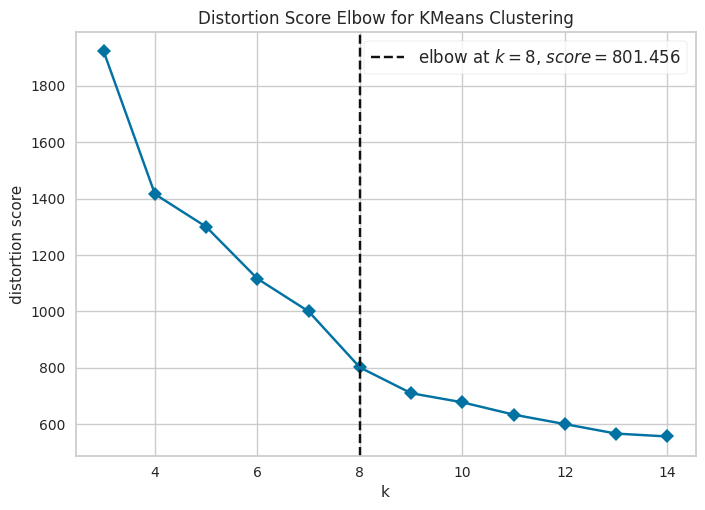

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
#Set-up the KElbowVisualizer
kBegin = 3
kEnd = 15
km = KMeans(random_state=111)
visualizer = KElbowVisualizer(km, k=(kBegin,kEnd), timings=False)
visualizer.fit(dtivo_std)
visualizer.show()

**Question**: **_As a marketing person, would you agree with setting the number of clusters to the one shown in the elbow?_**

*ANS*:


#### Silhouette Score
Considers both intra-cluster and inter-cluster distances adn scores that

##### Average Silhouette Score

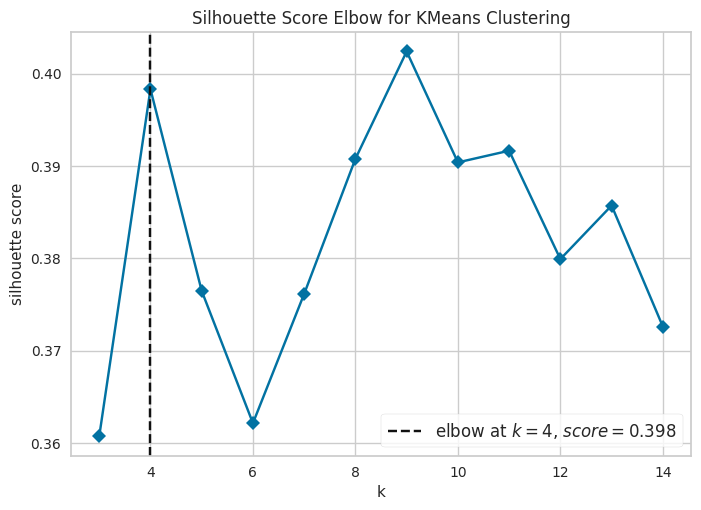

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [59]:
#Change the metric to 'silhouette'
vizElbowSil = KElbowVisualizer(km,
                               metric='silhouette',
                               k=(kBegin, kEnd),
                               timings=False)
vizElbowSil.fit(dtivo_std)
vizElbowSil.show()

##### Detailed Silhouette per Clustering

In [60]:
#Import Special Visualizer
from yellowbrick.cluster import SilhouetteVisualizer

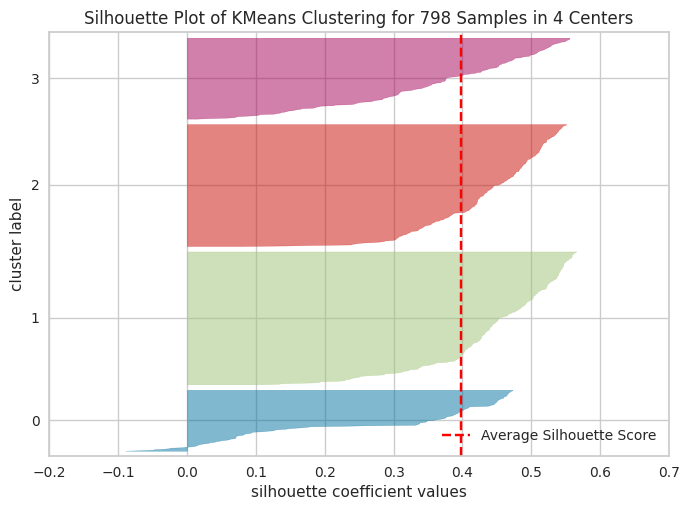

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 798 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [93]:
km = KMeans(n_clusters=4, random_state=111)
silViz = SilhouetteVisualizer(km, colors='yellowbrick')
silViz.fit(dtivo_std)
silViz.show()

##### How to Interpret the Plot



- **Cluster Cohesion and Separation**:
  - **High Silhouette Values**: Clusters with high silhouette values (close to +1) indicate that the samples are well-clustered and distinct from other clusters.
  - **Low or Negative Silhouette Values**: Clusters with low or negative silhouette values suggest that the samples are not well-clustered and may be overlapping with other clusters.

- **Cluster Size**:
  - The thickness of each silhouette plot indicates the size of the cluster. Thicker plots mean larger clusters.

- **Consistency Across Clusters**:
  - Ideally, you want clusters to have similar silhouette scores and sizes, indicating balanced and well-separated clusters.

**Q**: *Which cluster is best in terms of cohesion within?*


##### Key Components of a Silhouette Plot



1. **Silhouette Coefficient Values**:
   - **Range**: The silhouette coefficient ranges from -1 to 1.
   - **Interpretation**:
     - **+1**: Indicates that the sample is far away from the neighboring clusters, suggesting a good fit within its own cluster.
     - **0**: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
     - **-1**: Indicates that the sample might have been assigned to the wrong cluster.

2. **Silhouette Plot Structure**:
   - **X-axis**: Represents the silhouette coefficient values.
   - **Y-axis**: Represents the cluster labels.
   - **Width of Silhouette**: The width of each silhouette plot corresponds to the number of samples in that cluster.
   - **Color Coding**: Different colors are used to distinguish between different clusters.

3. **Average Silhouette Score**:
   - A vertical line is often drawn on the plot to indicate the average silhouette score for all samples. This helps to quickly assess the overall quality of the clustering.

##### Multiple Silhoette Plots

<Figure size 800x550 with 0 Axes>

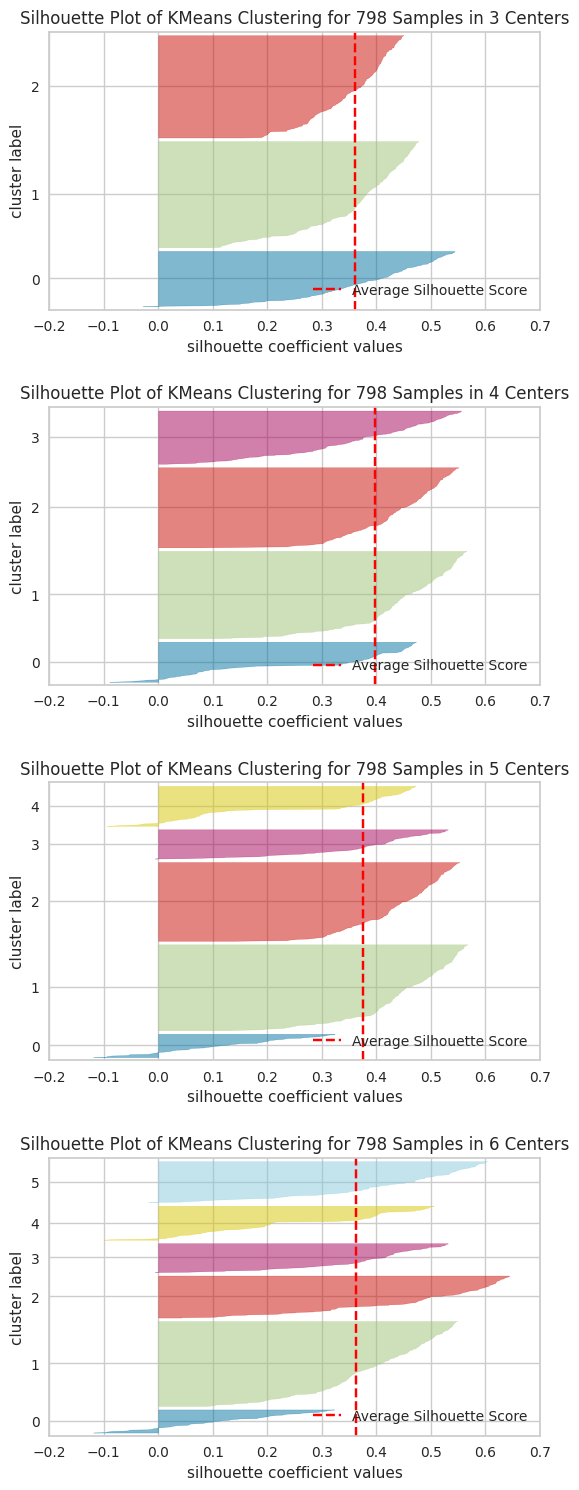

In [96]:
plt.clf()
kStart = 3
kStop = 7  #last k for which you want a subplot
subx = 0  #staring row index of subplot on which to plot
fig, ax = plt.subplots(kStop - kStart, 1,
                       figsize=(7, 16), sharex=True)
fig.tight_layout(pad=5.0)
for i in range(kStart, kStop):
    ax[subx].set_title(f"Silhouette values for k= {i}")
    ax[subx].tick_params(labelbottom=True)
    km = KMeans(n_clusters=i, random_state=111)
    silViz = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[subx])
    silViz.fit(dtivo_std)
    silViz.finalize()
    subx += 1

### EXERCISE-TODO: Cluster using OUR best k in k=3 to k=6 range


If you look at a silhouette plot and see that:
- Most of the silhouette values are close to +1, it means the clustering is good.
- If there are many values around 0, it suggests that the clusters are not well-separated.
- Negative values indicate that some samples might be in the wrong cluster.

By analyzing these aspects, you can determine the optimal number of clusters and the quality of your clustering.


#### Fitting the k-means model for k= ??

#### Tagging the segmentation bases dataset with cluster numbers

#### Cluster Analysis FOR k=??

#### Summary table, with descriptors and segment value

#### Box Plots of k=?? clusters by descriptors